# FaceForensics++ Dataset Preprocessing

This notebook extracts aligned faces from the FF++ dataset using MTCNN face detection.

**Features:**
- MTCNN face detection with GPU acceleration (CUDA)
- **Consecutive frame extraction**: 16 consecutive frames per video starting after frame 10
- **Random sampling**: 1000 videos per folder (independent selection, seed=42)
- Aligned face crop = 256×256 with margin = 0.25
- Reuses last bounding box when detection fails
- Skips already processed videos
- Organizes output by manipulation type and video ID

**Output Structure:**
```
FFPP_processed_temporal/
├── original/<video_id>/frame_0000.png        (1000 videos × 16 frames each)
├── Deepfakes/<video_id>/frame_0000.png       (1000 videos × 16 frames each)
├── Face2Face/<video_id>/frame_0000.png       (1000 videos × 16 frames each)
├── FaceShifter/<video_id>/frame_0000.png     (1000 videos × 16 frames each)
├── FaceSwap/<video_id>/frame_0000.png        (1000 videos × 16 frames each)
├── NeuralTextures/<video_id>/frame_0000.png  (1000 videos × 16 frames each)
└── DeepFakeDetection/<video_id>/frame_0000.png (1000 videos × 16 frames each)
```


## 1. Install Dependencies (If needed)


In [1]:
# Uncomment and run if packages are not installed
# !pip install facenet-pytorch opencv-python tqdm pillow matplotlib


## 2. Imports and Configuration


In [ ]:
import os
import cv2
import torch
import numpy as np
from pathlib import Path
from tqdm import tqdm
from facenet_pytorch import MTCNN
from PIL import Image
import warnings
warnings.filterwarnings('ignore')


# Base directory containing the FF++ raw videos
INPUT_BASE_DIR = Path(r"E:\University\FS2025\Scientific Writing\Project\FF+")

# Output directory for processed faces
OUTPUT_BASE_DIR = Path(r"E:\University\FS2025\Scientific Writing\Project\FFPP_processed_temporal")

# Folders to process (manipulation types)
MANIPULATION_TYPES = [
    "original",
    "Deepfakes",
    "Face2Face",
    "FaceShifter",
    "FaceSwap",
    "NeuralTextures",
    "DeepFakeDetection"
]

# Processing parameters
FACE_SIZE = 224        
MARGIN = 0.25          
MIN_FACE_SIZE = 60     

MAX_FRAMES_PER_VIDEO = 16  
START_FRAME_OFFSET = 10  

RANDOM_SEED = 42       
NUM_VIDEOS_PER_FOLDER = 1000 
np.random.seed(RANDOM_SEED)

print(f"🎲 Random seed: {RANDOM_SEED}")
print(f"📊 Videos per folder: {NUM_VIDEOS_PER_FOLDER} (independent random selection)")
print(f"🎬 Frames per video: {MAX_FRAMES_PER_VIDEO} (consecutive frames starting from frame {START_FRAME_OFFSET})")

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\n🔧 Using device: {DEVICE}")
if DEVICE.type == 'cuda':
    print(f"🎮 GPU: {torch.cuda.get_device_name(0)}")
    print(f"💾 GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
else:
    print("⚠️ CUDA not available - running on CPU (will be slower)")


🎲 Random seed: 42
📊 Videos per folder: 1000 (independent random selection)
🎬 Frames per video: 16 (consecutive frames starting from frame 10)

🔧 Using device: cuda
🎮 GPU: NVIDIA GeForce RTX 3060 Ti
💾 GPU Memory: 8.6 GB


## 3. Initialize MTCNN Face Detector


In [ ]:

mtcnn = MTCNN(
    image_size=FACE_SIZE,
    margin=0, 
    min_face_size=MIN_FACE_SIZE,
    thresholds=[0.6, 0.7, 0.7], 
    factor=0.709,
    post_process=False,  
    select_largest=True, 
    keep_all=False,
    device=DEVICE
)

print("✅ MTCNN initialized successfully!")


✅ MTCNN initialized successfully!


## 4. Helper Functions


In [ ]:
def get_video_id(video_path: Path) -> str:
    return video_path.stem


def expand_bbox_with_margin(bbox, margin, img_width, img_height):

    x1, y1, x2, y2 = bbox
    
    w = x2 - x1
    h = y2 - y1
    
    size = max(w, h)
    
    cx = (x1 + x2) / 2
    cy = (y1 + y2) / 2
    
    size_with_margin = size * (1 + margin * 2)

    new_x1 = cx - size_with_margin / 2
    new_y1 = cy - size_with_margin / 2
    new_x2 = cx + size_with_margin / 2
    new_y2 = cy + size_with_margin / 2
    
    new_x1 = max(0, int(new_x1))
    new_y1 = max(0, int(new_y1))
    new_x2 = min(img_width, int(new_x2))
    new_y2 = min(img_height, int(new_y2))
    
    return [new_x1, new_y1, new_x2, new_y2]


def extract_and_resize_face(frame_rgb, bbox, target_size=256):
    x1, y1, x2, y2 = bbox

    x1, y1 = max(0, x1), max(0, y1)
    x2, y2 = min(frame_rgb.shape[1], x2), min(frame_rgb.shape[0], y2)
    
    face = frame_rgb[y1:y2, x1:x2]
    
    if face.size == 0:
        return None

    face_resized = cv2.resize(face, (target_size, target_size), interpolation=cv2.INTER_LANCZOS4)
    
    return face_resized


def detect_face_bbox(frame_rgb, mtcnn_detector):

    pil_image = Image.fromarray(frame_rgb)
    
    boxes, probs = mtcnn_detector.detect(pil_image)
    
    if boxes is not None and len(boxes) > 0:
        return boxes[0].tolist()
    
    return None


def is_video_processed(output_folder: Path, min_frames: int = 1) -> bool:

    if not output_folder.exists():
        return False

    png_files = list(output_folder.glob("*.png"))
    return len(png_files) >= min_frames


print("✅ Helper functions defined!")


✅ Helper functions defined!


## 5. Main Video Processing Function


In [ ]:
def process_video(video_path: Path, output_folder: Path, 
                  max_frames: int = 3, face_size: int = 256, 
                  margin: float = 0.25, mtcnn_detector=None,
                  start_frame_offset: int = 10) -> dict:
    stats = {
        'total_frames': 0,
        'sampled_frames': 0,
        'faces_detected': 0,
        'faces_reused': 0,
        'faces_saved': 0,
        'failed_frames': 0
    }

    output_folder.mkdir(parents=True, exist_ok=True)

    cap = cv2.VideoCapture(str(video_path))
    if not cap.isOpened():
        print(f"  ⚠️ Failed to open video: {video_path.name}")
        return stats
    
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    stats['total_frames'] = total_frames

    start_frame = start_frame_offset
    end_frame = start_frame + max_frames

    if total_frames <= start_frame:
        cap.release()
        return stats
    
    available_frames = total_frames - start_frame
    num_frames_to_extract = min(max_frames, available_frames)
    
    target_frame_indices = list(range(start_frame, start_frame + num_frames_to_extract))
    
    stats['sampled_frames'] = len(target_frame_indices)
    last_bbox = None  
    
    cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
    
    for sample_idx, target_frame_idx in enumerate(target_frame_indices):
        ret, frame = cap.read()
        
        if not ret:
            stats['failed_frames'] += 1
            continue

        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        img_height, img_width = frame_rgb.shape[:2]

        bbox = detect_face_bbox(frame_rgb, mtcnn_detector)
        
        if bbox is not None:
            stats['faces_detected'] += 1
            last_bbox = bbox  
        elif last_bbox is not None:
            bbox = last_bbox
            stats['faces_reused'] += 1
        else:
            stats['failed_frames'] += 1
            continue

        expanded_bbox = expand_bbox_with_margin(bbox, margin, img_width, img_height)

        face_img = extract_and_resize_face(frame_rgb, expanded_bbox, face_size)
        
        if face_img is not None:
            output_path = output_folder / f"frame_{target_frame_idx:04d}.png"
            cv2.imwrite(str(output_path), cv2.cvtColor(face_img, cv2.COLOR_RGB2BGR))
            stats['faces_saved'] += 1
        else:
            stats['failed_frames'] += 1
    
    cap.release()
    return stats


print("✅ Video processing function defined!")


✅ Video processing function defined!


## 6. Process All Folders


In [ ]:
def process_manipulation_folder(manipulation_type: str, input_base: Path, 
                                 output_base: Path, mtcnn_detector) -> dict:

    input_folder = input_base / manipulation_type
    output_folder = output_base / manipulation_type
    
    if not input_folder.exists():
        print(f"⚠️ Folder not found: {input_folder}")
        return None

    video_extensions = ['*.mp4', '*.avi', '*.mov', '*.mkv']
    all_video_files = []
    for ext in video_extensions:
        all_video_files.extend(list(input_folder.glob(ext)))
    
    all_video_files = sorted(all_video_files)
    
    if len(all_video_files) == 0:
        print(f"⚠️ No videos found in: {input_folder}")
        return None

    n_to_sample = min(NUM_VIDEOS_PER_FOLDER, len(all_video_files))
    sampled_indices = np.random.choice(len(all_video_files), size=n_to_sample, replace=False)
    video_files = [all_video_files[i] for i in sorted(sampled_indices)]
    
    print(f"\n{'='*60}")
    print(f"📁 Processing: {manipulation_type}")
    print(f"   Total videos in folder: {len(all_video_files)}")
    print(f"   Randomly sampled: {len(video_files)}")
    print(f"{'='*60}")
    
    folder_stats = {
        'total_videos': len(video_files),
        'processed_videos': 0,
        'skipped_videos': 0,
        'total_faces_saved': 0,
        'total_faces_detected': 0,
        'total_faces_reused': 0
    }

    for video_path in tqdm(video_files, desc=f"  {manipulation_type}", unit="video"):
        video_id = get_video_id(video_path)
        video_output_folder = output_folder / video_id

        if is_video_processed(video_output_folder, min_frames=1):
            folder_stats['skipped_videos'] += 1
            continue

        video_stats = process_video(
            video_path=video_path,
            output_folder=video_output_folder,
            max_frames=MAX_FRAMES_PER_VIDEO,
            face_size=FACE_SIZE,
            margin=MARGIN,
            mtcnn_detector=mtcnn_detector,
            start_frame_offset=START_FRAME_OFFSET
        )
        
        folder_stats['processed_videos'] += 1
        folder_stats['total_faces_saved'] += video_stats['faces_saved']
        folder_stats['total_faces_detected'] += video_stats['faces_detected']
        folder_stats['total_faces_reused'] += video_stats['faces_reused']

    print(f"\n  📊 Summary for {manipulation_type}:")
    print(f"     - Videos processed: {folder_stats['processed_videos']}")
    print(f"     - Videos skipped (already done): {folder_stats['skipped_videos']}")
    print(f"     - Total faces saved: {folder_stats['total_faces_saved']}")
    print(f"     - Faces detected: {folder_stats['total_faces_detected']}")
    print(f"     - Faces reused (from last bbox): {folder_stats['total_faces_reused']}")
    
    return folder_stats


print("✅ Folder processing function defined!")


✅ Folder processing function defined!


## 7. Run Full Processing Pipeline

⚠️ **This cell will process all videos. It may take several hours depending on your GPU.**


In [ ]:
def run_preprocessing():

    print("\n" + "="*60)
    print("🚀 FaceForensics++ Preprocessing Pipeline")
    print("="*60)
    print(f"\n📂 Input directory:  {INPUT_BASE_DIR}")
    print(f"📂 Output directory: {OUTPUT_BASE_DIR}")
    print(f"\n⚙️ Settings:")
    print(f"   - Frames per video: {MAX_FRAMES_PER_VIDEO} (consecutive frames starting from frame {START_FRAME_OFFSET})")
    print(f"   - Face size: {FACE_SIZE}x{FACE_SIZE}")
    print(f"   - Margin: {MARGIN*100:.0f}%")
    print(f"   - Device: {DEVICE}")
    print(f"\n🎲 Random Sampling:")
    print(f"   - Seed: {RANDOM_SEED}")
    print(f"   - Videos per folder: {NUM_VIDEOS_PER_FOLDER} (independent selection)")
    print(f"\n📋 Folders to process: {MANIPULATION_TYPES}")

    OUTPUT_BASE_DIR.mkdir(parents=True, exist_ok=True)

    all_stats = {}
    
    for manipulation_type in MANIPULATION_TYPES:
        stats = process_manipulation_folder(
            manipulation_type=manipulation_type,
            input_base=INPUT_BASE_DIR,
            output_base=OUTPUT_BASE_DIR,
            mtcnn_detector=mtcnn
        )
        if stats:
            all_stats[manipulation_type] = stats

    print("\n" + "="*60)
    print("✅ PREPROCESSING COMPLETE!")
    print("="*60)
    
    total_videos = sum(s['total_videos'] for s in all_stats.values())
    total_processed = sum(s['processed_videos'] for s in all_stats.values())
    total_skipped = sum(s['skipped_videos'] for s in all_stats.values())
    total_faces = sum(s['total_faces_saved'] for s in all_stats.values())
    
    print(f"\n📊 FINAL SUMMARY:")
    print(f"   - Total videos found: {total_videos}")
    print(f"   - Videos processed: {total_processed}")
    print(f"   - Videos skipped: {total_skipped}")
    print(f"   - Total faces extracted: {total_faces}")
    print(f"\n📂 Output saved to: {OUTPUT_BASE_DIR}")
    
    return all_stats

all_stats = run_preprocessing()



🚀 FaceForensics++ Preprocessing Pipeline

📂 Input directory:  E:\University\FS2025\Scientific Writing\Project\FF+
📂 Output directory: E:\University\FS2025\Scientific Writing\Project\FFPP_processed_temporal

⚙️ Settings:
   - Frames per video: 16 (consecutive frames starting from frame 10)
   - Face size: 224x224
   - Margin: 25%
   - Device: cuda

🎲 Random Sampling:
   - Seed: 42
   - Videos per folder: 1000 (independent selection)

📋 Folders to process: ['original', 'Deepfakes', 'Face2Face', 'FaceShifter', 'FaceSwap', 'NeuralTextures', 'DeepFakeDetection']

📁 Processing: original
   Total videos in folder: 1000
   Randomly sampled: 1000


  original: 100%|██████████| 1000/1000 [15:30<00:00,  1.07video/s]



  📊 Summary for original:
     - Videos processed: 1000
     - Videos skipped (already done): 0
     - Total faces saved: 16000
     - Faces detected: 16000
     - Faces reused (from last bbox): 0

📁 Processing: Deepfakes
   Total videos in folder: 1000
   Randomly sampled: 1000


  Deepfakes: 100%|██████████| 1000/1000 [14:59<00:00,  1.11video/s]



  📊 Summary for Deepfakes:
     - Videos processed: 1000
     - Videos skipped (already done): 0
     - Total faces saved: 15983
     - Faces detected: 15980
     - Faces reused (from last bbox): 3

📁 Processing: Face2Face
   Total videos in folder: 1000
   Randomly sampled: 1000


  Face2Face: 100%|██████████| 1000/1000 [15:11<00:00,  1.10video/s]



  📊 Summary for Face2Face:
     - Videos processed: 1000
     - Videos skipped (already done): 0
     - Total faces saved: 16000
     - Faces detected: 16000
     - Faces reused (from last bbox): 0

📁 Processing: FaceShifter
   Total videos in folder: 1000
   Randomly sampled: 1000


  FaceShifter: 100%|██████████| 1000/1000 [15:20<00:00,  1.09video/s]



  📊 Summary for FaceShifter:
     - Videos processed: 1000
     - Videos skipped (already done): 0
     - Total faces saved: 16000
     - Faces detected: 16000
     - Faces reused (from last bbox): 0

📁 Processing: FaceSwap
   Total videos in folder: 1000
   Randomly sampled: 1000


  FaceSwap: 100%|██████████| 1000/1000 [15:13<00:00,  1.09video/s]



  📊 Summary for FaceSwap:
     - Videos processed: 1000
     - Videos skipped (already done): 0
     - Total faces saved: 16000
     - Faces detected: 15999
     - Faces reused (from last bbox): 1

📁 Processing: NeuralTextures
   Total videos in folder: 1000
   Randomly sampled: 1000


  NeuralTextures: 100%|██████████| 1000/1000 [15:20<00:00,  1.09video/s]



  📊 Summary for NeuralTextures:
     - Videos processed: 1000
     - Videos skipped (already done): 0
     - Total faces saved: 16000
     - Faces detected: 16000
     - Faces reused (from last bbox): 0

📁 Processing: DeepFakeDetection
   Total videos in folder: 1000
   Randomly sampled: 1000


  DeepFakeDetection: 100%|██████████| 1000/1000 [22:40<00:00,  1.36s/video]


  📊 Summary for DeepFakeDetection:
     - Videos processed: 1000
     - Videos skipped (already done): 0
     - Total faces saved: 15948
     - Faces detected: 15944
     - Faces reused (from last bbox): 4

✅ PREPROCESSING COMPLETE!

📊 FINAL SUMMARY:
   - Total videos found: 7000
   - Videos processed: 7000
   - Videos skipped: 0
   - Total faces extracted: 111931

📂 Output saved to: E:\University\FS2025\Scientific Writing\Project\FFPP_processed_temporal


## 8. Verify Output Structure (Optional)


In [ ]:
def verify_output_structure():
    print("\n📁 Output Directory Structure:")
    print("="*50)
    
    for manipulation_type in MANIPULATION_TYPES:
        type_folder = OUTPUT_BASE_DIR / manipulation_type
        if not type_folder.exists():
            print(f"  ⚠️ {manipulation_type}: Not found")
            continue
        
        video_folders = sorted([f for f in type_folder.iterdir() if f.is_dir()])
        total_faces = sum(len(list(f.glob("*.png"))) for f in video_folders)
        
        print(f"\n  📁 {manipulation_type}/")
        print(f"     - Video folders: {len(video_folders)}")
        print(f"     - Total face images: {total_faces}")

        if video_folders:
            print(f"     - Sample videos:")
            for vf in video_folders[:3]:
                n_frames = len(list(vf.glob("*.png")))
                print(f"       └── {vf.name}/ ({n_frames} frames)")
            if len(video_folders) > 3:
                print(f"       └── ... and {len(video_folders) - 3} more")

verify_output_structure()



📁 Output Directory Structure:

  📁 original/
     - Video folders: 1000
     - Total face images: 16000
     - Sample videos:
       └── 000/ (16 frames)
       └── 001/ (16 frames)
       └── 002/ (16 frames)
       └── ... and 997 more

  📁 Deepfakes/
     - Video folders: 1000
     - Total face images: 15983
     - Sample videos:
       └── 000_003/ (16 frames)
       └── 001_870/ (16 frames)
       └── 002_006/ (16 frames)
       └── ... and 997 more

  📁 Face2Face/
     - Video folders: 1000
     - Total face images: 16000
     - Sample videos:
       └── 000_003/ (16 frames)
       └── 001_870/ (16 frames)
       └── 002_006/ (16 frames)
       └── ... and 997 more

  📁 FaceShifter/
     - Video folders: 1000
     - Total face images: 16000
     - Sample videos:
       └── 000_003/ (16 frames)
       └── 001_870/ (16 frames)
       └── 002_006/ (16 frames)
       └── ... and 997 more

  📁 FaceSwap/
     - Video folders: 1000
     - Total face images: 16000
     - Sample videos:


## 9. Display Sample Extracted Faces (Optional)


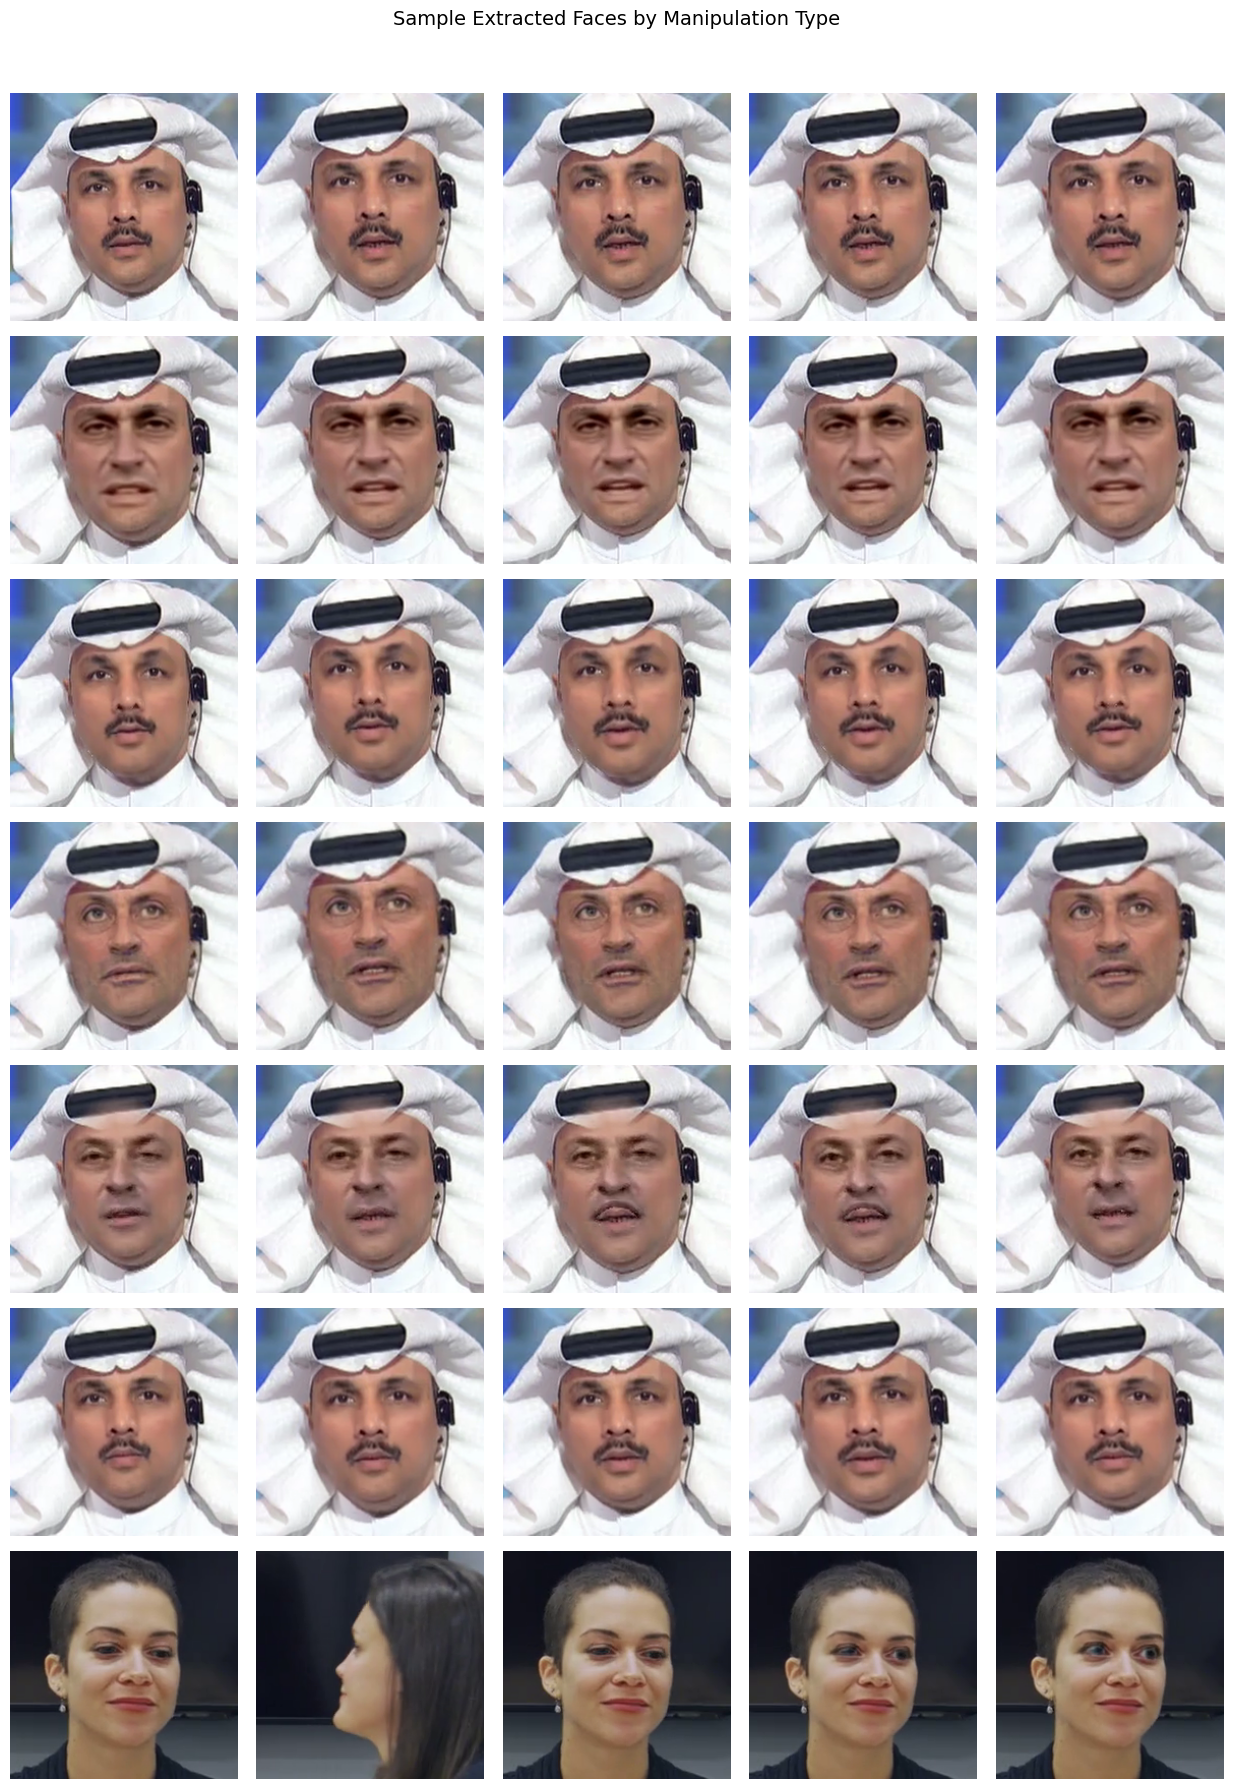

In [ ]:
import matplotlib.pyplot as plt

def display_sample_faces(n_samples=5):
    available_types = []
    for mt in MANIPULATION_TYPES:
        type_folder = OUTPUT_BASE_DIR / mt
        if type_folder.exists() and any(type_folder.glob("*/*.png")):
            available_types.append(mt)
    
    if not available_types:
        print("⚠️ No processed faces found to display.")
        return
    
    n_rows = len(available_types)
    fig, axes = plt.subplots(n_rows, n_samples, figsize=(n_samples*2.5, n_rows*2.5))

    if n_rows == 1:
        axes = [axes]
    
    for row, manipulation_type in enumerate(available_types):
        type_folder = OUTPUT_BASE_DIR / manipulation_type

        face_images = sorted(list(type_folder.glob("*/*.png")))[:n_samples]
        
        for col in range(n_samples):
            ax = axes[row][col] if n_rows > 1 else axes[col]
            
            if col < len(face_images):
                img = cv2.imread(str(face_images[col]))
                img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                ax.imshow(img_rgb)
                if col == 0:
                    ax.set_ylabel(manipulation_type, fontsize=10, rotation=0, ha='right', va='center')
            
            ax.axis('off')
    
    plt.suptitle("Sample Extracted Faces by Manipulation Type", fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

display_sample_faces(n_samples=5)
